# Model Definition 

This Watson Studio notebook is used to define the models that will be used to detect between fraudulent and non-fraudulent transactions. Two models will be used. For the regular ML model, we will compare the evaluation scores of 7 different models in order to compare the best of the ML models versus the DL model. In order to train multiple models quickly and allow computation speed to be within acceptable range, the model will be limited to 1,000 fraud samples and 1,000 non-fraud samples.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression as LRR
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn import model_selection

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.models import Sequential
from keras import optimizers
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

## Model I : Regular ML models:

In order to deal with the unbalanced data set and to make our computation times quicker we sample a data set of 1,000 fraud and 1,000 non-fraud cases

In [4]:
# Set seed to have reproducibility
seed =10
np.random.seed(10)

# Set Training Parameters 
TRAIN_SAMPLE = 200000

# Set Validation Size
VALIDATION_SIZE = .2

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
## We scale the only two columns that need to be scaled "Time" and "Column"
scaler = MinMaxScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

#### We must do Oversampling and Undersampling to prevent the following:
1. We do not want to train our model to believe that the probability of classification is skewed to one side or the other. We want the model to be confident that a fraud occurs
2. Certain features the "v" columns have separate correlations to the classification models. Because we have so many more non frauds it makes it very difficult to see any correlations.

In [8]:
non_fraud = df[df['Class'] == 0].sample(350)
fraud = df[df['Class'] == 1].sample(350)

df_350 = non_fraud.append(fraud).reset_index()
X_350 = df_350.drop(['Class'], axis = 1)
X_350 = X_350.drop(["index"],axis =1)
Y_350 = df_350["Class"]

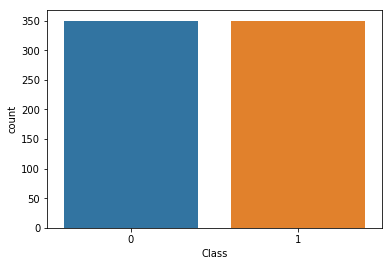

In [9]:
sns.countplot('Class',data =df_350)

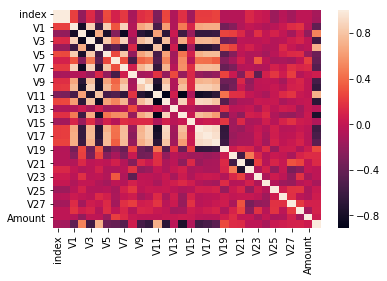

In [10]:
df_350_corr = df_350.corr()
sns.heatmap(df_350_corr)

Here we have a DataFrame with an equal amount of fraudulent and non-fraudulent cases. This new correlation heatmap demonstrates a much different correlation between the variables than the one in the unbalanced dataset. It will be this which will help train our models. 

### I. Logistic Regression

In [11]:
lr = LRR()
kfold = model_selection.KFold(n_splits=10,random_state = seed)
x_train_lr,x_test_lr,y_train_lr,y_test_lr = model_selection.train_test_split(X_350,Y_350,test_size = .3, random_state=seed)
lr.fit(x_train_lr,y_train_lr)
prediction_lr = lr.predict(x_test_lr)
report_lr = classification_report(y_test_lr,prediction_lr)
print(report_lr)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       113
           1       0.95      0.90      0.92        97

   micro avg       0.93      0.93      0.93       210
   macro avg       0.93      0.93      0.93       210
weighted avg       0.93      0.93      0.93       210



/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
test_df_x  = df.drop("Class",axis = 1)
test_df_y  = df["Class"]

In [13]:
prediction_true=lr.predict(test_df_x)
report_lr_true = classification_report(test_df_y,prediction_true)
print(report_lr_true)

              precision    recall  f1-score   support

           0       1.00      0.95      0.98    284315
           1       0.03      0.93      0.07       492

   micro avg       0.95      0.95      0.95    284807
   macro avg       0.52      0.94      0.52    284807
weighted avg       1.00      0.95      0.97    284807



### Confusion Matrix

Text(33.0, 0.5, 'True Label')

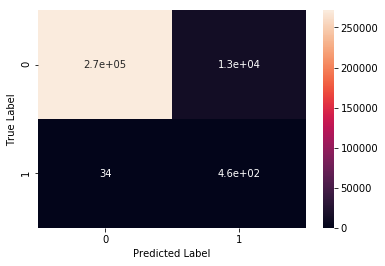

In [14]:
results = confusion_matrix(test_df_y, prediction_true)

sns.heatmap(results,annot =True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

### Logistic Regression With Spark ML

Now we will implement the model on Apache Spark ML in order to run all of our ML on the cloud.

In [15]:
# The code was removed by Watson Studio for sharing.

NOTE: A pipeline that has created a normalized features vector column has already been applied to the dataframe 'df_engin.parquet'.

In [16]:
df_spark.show()

+-----+--------------------+--------------------+
|label|            features|       features_norm|
+-----+--------------------+--------------------+
|    0|[0.0,-1.359807133...|[0.0,-0.008352305...|
|    0|[0.0,1.1918571113...|[0.0,0.0990160021...|
|    0|[1.0,-1.358354061...|[0.00247767129574...|
|    0|[1.0,-0.966271711...|[0.00708831461517...|
|    0|[2.0,-1.158233093...|[0.02296611443072...|
|    0|[2.0,-0.425965884...|[0.12744239703997...|
|    0|[4.0,1.2296576345...|[0.21045578224598...|
|    0|[7.0,-0.644269442...|[0.09609968216933...|
|    0|[7.0,-0.894286082...|[0.06055060797294...|
|    0|[9.0,-0.338261752...|[0.34989303344852...|
|    0|[10.0,1.449043781...|[0.27866855142573...|
|    0|[10.0,0.384978215...|[0.27152489312668...|
|    0|[10.0,1.249998742...|[0.06667393065300...|
|    0|[11.0,1.069373587...|[0.21923935251122...|
|    0|[12.0,-2.79185476...|[0.12794986433141...|
|    0|[12.0,-0.75241704...|[0.26031125157463...|
|    0|[12.0,1.103215435...|[0.32245660558223...|


We split the data into 70% training data and 30% test data.

### Train/Validate/Split

In [17]:
splits = df_spark.randomSplit((0.7,0.3))
df_spark_train = splits[0]
df_spark_test = splits[1]

### Model Definition

In [18]:
lr_spark= LogisticRegression(featuresCol='features_norm', labelCol='label',maxIter = 10)

### Model Training

In [19]:
model_lr_spark = lr_spark.fit(df_spark_train)
prediction_lr_spark = model_lr_spark.transform(df_spark_train)
prediction_lr_spark.show()

+-----+--------------------+--------------------+--------------------+--------------------+----------+
|label|            features|       features_norm|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+----------+
|    0|[0.0,-1.359807133...|[0.0,-0.008352305...|[13.5182023920399...|[0.99999865377171...|       0.0|
|    0|[0.0,1.1918571113...|[0.0,0.0990160021...|[109.326386025279...|[1.0,3.3124842561...|       0.0|
|    0|[1.0,-0.966271711...|[0.00708831461517...|[7.76327668103136...|[0.99957511909516...|       0.0|
|    0|[2.0,-1.158233093...|[0.02296611443072...|[20.5376603739464...|[0.99999999879605...|       0.0|
|    0|[2.0,-0.425965884...|[0.12744239703997...|[71.9681229242800...|[1.0,5.5544535728...|       0.0|
|    0|[4.0,1.2296576345...|[0.21045578224598...|[3.17316839826945...|[0.95981197723883...|       0.0|
|    0|[7.0,-0.894286082...|[0.06055060797294...|[20.5085097166776...|[0.

### Model Evaluation

In [20]:
evaluator_lr_spark = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_lr_spark = evaluator_lr_spark.evaluate(prediction_lr_spark)
print("Test Error = %g" % (1.0 - accuracy_lr_spark))

Test Error = 0.00150336


In [21]:
model_lr_spark.summary

In [22]:
evaluator_lr_spark_bin = BinaryClassificationEvaluator()
evaluator_lr_spark_bin.evaluate(prediction_lr_spark)

0.9372067249745129

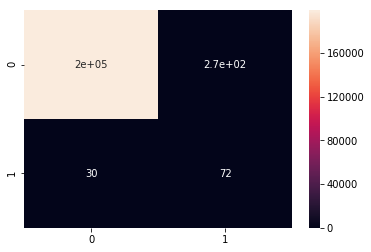

In [23]:
x_lr_spark= prediction_lr_spark.select("prediction").toPandas()
y_lr_spark =prediction_lr_spark.select("label").toPandas()
results_lr_spark=confusion_matrix(x_lr_spark,y_lr_spark)
sns.heatmap(results_lr_spark,annot =True)

## Model II : Deep Learning Algorithm using TensorFlow and Keras, Autoencoder:


We first import the DataFrame from the .csv file. 

In [24]:
body = client_6543831d1aa4422e929557ca99f11127.get_object(Bucket='advanceddatasciencebyibm-donotdelete-pr-riycgf7njashok',Key='creditcard.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_ai= pd.read_csv(body)
df_ai.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Cleaning the Dataset

In [25]:
df_ai.columns = map(str.lower, df_ai.columns)
df_ai.rename(columns={'class': 'label'}, inplace=True)
df_ai['log10_amount'] = np.log10(df_ai.amount + 0.00001)
# print first 5 rows to get an initial impression of the data we're dealing with
df_ai.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v22,v23,v24,v25,v26,v27,v28,amount,label,log10_amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,2.174990
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.429754
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,2.578249
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,2.091667
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.845036


In order to implement the autoencoder algorithm, we will have two models. One to tearing the weights for the appropriate latent representation of the weights and then a classifier to predict whether a given transaction is fraudulent or not. 

We first separate the dataset into a train set and a test set.

In [26]:
FRAUD_RATIO = 10

df_ai = df_ai.drop(["time","amount"], axis =1)
fraud_df = df_ai[df_ai.label ==1]
clean_df = df_ai[df_ai.label ==0]
clean_df.shape

(284315, 30)

In [27]:
clean_Undersampled_df = clean_df.sample(int(len(fraud_df)*FRAUD_RATIO),random_state = seed)
visual = pd.concat([fraud_df,clean_Undersampled_df])
column_Names = list(visual.drop('label',axis=1).columns)
features, labels = visual.drop('label', axis=1).values, \
                   visual.label.values

In [28]:
def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('Error')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=seed).fit_transform(features)
    
   
    fig, ax = plt.subplots(figsize=(8,8))
    
    
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    
    plt.legend(loc='best')
    plt.savefig(save_as)
    plt.show

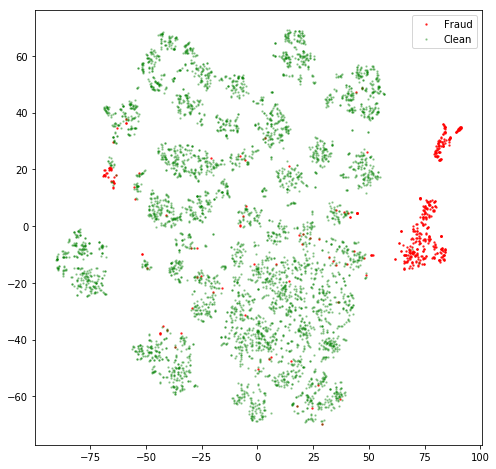

In [29]:
tsne_scatter(features,labels,dimensions=2,save_as = 'tsne_initial.png')

Here we can see that we can separate the fraudulent cases from the non-fraudulent cases in the undersampled dataset.

### Train/Validate/Split

For the encoder, we will train, test, and validate our data in the following way:

1. Training
    A. Actual Training of Our Encoder 
    B. Validation of Neural Network (Generalization)

2. Testing: Mix of fraud and non-fraud
    A. Apply Threshold

In [30]:
clean_df.shape

(284315, 30)

In [31]:
fraud_df.shape

(492, 30)

In [32]:
clean_df = clean_df.sample(frac=1).reset_index(drop=True)

X_train = clean_df.iloc[:TRAIN_SAMPLE].drop('label', axis=1)

X_test = clean_df.iloc[TRAIN_SAMPLE:].append(fraud_df).sample(frac=1)

X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATION_SIZE, 
                                       random_state=seed)

X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values

### Normalizing and Scaling Pipeline

In [33]:
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [34]:
pipeline.fit(X_train)
X_train_tran = pipeline.transform(X_train)
X_validate_tran = pipeline.transform(X_validate)

### Model Definition With Keras

In [35]:
INPUT_DIM = X_train_tran.shape[1]
LATENT_DIM = 2
BATCH_SIZE = 256
EPOCHS = 30

In [36]:
autoencoder = Sequential()
autoencoder.add(Dense(INPUT_DIM,activation ='elu',input_shape=(INPUT_DIM,)))
autoencoder.add(Dense(LATENT_DIM, activation = 'elu'))
autoencoder.add(Dense(INPUT_DIM, activation = 'elu'))
autoencoder.compile(optimizer = 'adam',loss='mse',metrics=['acc'])
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 29)                870       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 60        
_________________________________________________________________
dense_3 (Dense)              (None, 29)                87        
Total params: 1,017
Trainable params: 1,017
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [37]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        sys.stdout.write(str(logs.get('loss'))+str(', '))
        sys.stdout.flush()
        self.losses.append(logs.get('loss'))
        
lr_hist_ai = LossHistory()

In [38]:
model = autoencoder.fit(X_train_tran,X_train_tran,
                        epochs= EPOCHS,
                        callbacks=[lr_hist_ai],
                        batch_size = BATCH_SIZE, 
                        shuffle=True,
                        validation_data = (X_validate_tran, X_validate_tran))

Instructions for updating:
Use tf.cast instead.


Train on 160000 samples, validate on 40000 samples
Epoch 1/30
160000/160000 [==============================] - 3s 18us/step - loss: 0.0518 - acc: 0.1551 - val_loss: 0.0162 - val_acc: 0.254642768, 0.2641232, 0.25530827, 0.25499672, 0.25143957, 0.24782577, 0.24925122, 0.24324991, 0.24280426, 0.23844554, 0.23609327, 0.23273215, 0.23391244, 0.2293275,0.22568156, 0.22862244, 0.2264873, 0.22716776, 0.22542028, 0.22422802, 0.22203904, 0.22077034, 0.21971431, 0.2171533, 0.21648002, 0.21368983, 0.21205331, 0.21196115, 0.20946309, 0.20976254, 0.20760374, 0.20493785, 0.204880040.20236933, 0.20044747, 0.19908608, 0.20162092, 0.19783027, 0.19587022, 0.19612278, 0.19248745, 0.19262466, 0.19282955, 0.19019134, 0.18850708, 0.18708391, 0.18335551, 0.18352778, 0.1833822, 0.18118997, 0.18102437, 0.17831501, 0.177881660.17697555, 0.17668094, 0.17376408, 0.17183223, 0.17330693, 0.17064142, 0.1702873, 0.16983424, 0.16608234, 0.16632995, 0.16504276, 0.16212332, 0.16022718, 0.16005689, 0.15975416, 0.1575501,0

In [39]:
X_test_tran = pipeline.transform(X_test)
reconstructions = autoencoder.predict(X_test_tran)

### Model Evaluation

In [40]:
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

def detect_mad_outliers(points, threshold=3.5):  
    
   
    median = np.median(points, axis=0)
    deviation = np.abs(points - median)
    med_abs_deviation = np.median(deviation)
    modified_z_score = 0.6745 * deviation / med_abs_deviation
    
    idx = (np.abs(modified_z_score - threshold)).argmin()
    threshold_value = points[idx]

    return modified_z_score, threshold_value

Z_SCORE= 3

# find the outliers on the reconstructions' MSEs
mad_z_scores, threshold_value = detect_mad_outliers(mse, threshold=Z_SCORE)
mad_outliers = (mad_z_scores > Z_SCORE).astype(int)
anomalies = len(mad_outliers[mad_outliers==True])
total_trades = len(y_test)

Text(33.0, 0.5, 'True Label')

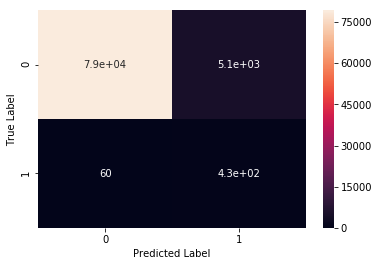

In [41]:
cm = confusion_matrix(y_test, mad_outliers)

sns.heatmap(cm,annot =True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [42]:
cm[1][1]/(cm[1][0] + cm[1][1])

0.8780487804878049

## Results

Now we have the results of both the logistic regression on as a Spark job and the autoencoder.

In [43]:
print("The accuracy of the of the autoencoder in detecting the fraudulent credit cards: %.3f" %(cm[1][1]/(cm[1][0] + cm[1][1])))
print("The accuracy of the of the logistic regression in detecting the fraudulent credit cards: %.3f" %(results[1][1]/(results[1][0] + results[1][1])))

The accuracy of the of the autoencoder in detecting the fraudulent credit cards: 0.878
The accuracy of the of the logistic regression in detecting the fraudulent credit cards: 0.931


## Recall/Precision/AUROC


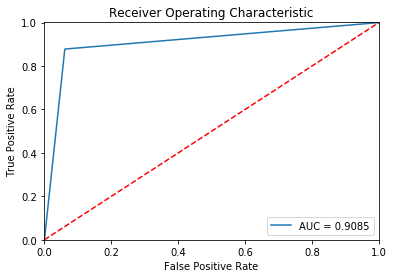

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, mad_outliers)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

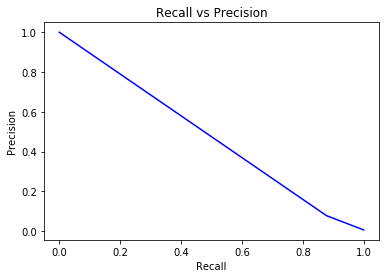

In [45]:
precision, recall, th = precision_recall_curve(y_test, mad_outliers)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()